<a href="https://colab.research.google.com/github/jithinraj9895/CopyHelper-CH/blob/master/Clean_Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
   from torchvision.datasets import ImageFolder
   from torchvision.transforms import ToTensor
   import torchvision.transforms as transforms

In [70]:
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader
import torch

import os
dir = "/content/drive/MyDrive/mnist_stego"

dataset = ImageFolder(dir, transform= transforms.Compose([ transforms.Grayscale(num_output_channels=1), ToTensor()]))

train_dl = DataLoader(dataset, batch_size=32,shuffle= True)

In [71]:
print(len(train_dl))

190


In [ ]:
print(dataset.classes)

['cover', 'stego']


In [4]:
data = next(iter(train_dl))
inputs, labels = data

print(inputs.shape)
print(labels)

torch.Size([32, 1, 28, 28])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0,
        0, 1, 0, 0, 0, 0, 0, 1])


In [13]:
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np
import PIL as image
import pickle as pl

srm_dir = "/content/drive/MyDrive"
SRM_npy = np.load(os.path.join(srm_dir,"SRM_Kernels.npy"))

In [14]:
import torch.nn as nn
import torch.nn.functional as F

In [7]:
def activation(x):
  a = torch.ones(x.shape)
  a = torch.mul(a, 3)
  return torch.where(x > -3,x,a)


class the_tlu(nn.Module):
    def __init__(self):
        super(the_tlu, self).__init__()
        
    def forward(self, x):
        return activation(x)

In [8]:
import torch
import torch.nn as nn
from torch.optim.adamax import Adamax
from torch.optim.adadelta import Adadelta
import numpy as np
import torch
import torch.nn.functional as F
from torch import nn
from torch.nn import Parameter

In [15]:


class SRMConv2d(nn.Module):

    def __init__(self, stride=1, padding=0):
        super(SRMConv2d, self).__init__()
        self.in_channels = 1
        self.out_channels = 30
        self.kernel_size = (5, 5)
        if isinstance(stride, int):
            self.stride = (stride, stride)
        else:
            self.stride = stride
        if isinstance(padding, int):
            self.padding = (padding, padding)
        else:
            self.padding = padding
        self.dilation = (1, 1)
        self.transpose = False
        self.output_padding = (0,)
        self.groups = 1
        self.weight = Parameter(torch.Tensor(30, 1, 5, 5), requires_grad=True)
        self.bias = Parameter(torch.Tensor(30), requires_grad=True)
        self.reset_parameters()

    def reset_parameters(self):
        self.weight.data.numpy()[:] = SRM_npy
        self.bias.data.zero_()

    def forward(self, input):
        return F.conv2d(input, self.weight, self.bias, self.stride, self.padding,
                        self.dilation, self.groups)


class BlockA(nn.Module):

    def __init__(self, in_planes, out_planes, norm_layer=None,activation = nn.ReLU(inplace=True)):
        super(BlockA, self).__init__()

        if norm_layer is None:
            norm_layer = nn.BatchNorm2d

        self.conv1 = conv3x3(in_planes, out_planes)
        self.bn1 = norm_layer(out_planes)
        self.conv2 = conv3x3(out_planes, out_planes)
        self.bn2 = norm_layer(out_planes)

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += identity
        out = self.relu(out)

        return out

In [18]:

def accuracy(outputs, labels):
    _, argmax = torch.max(outputs, 1)
    return (labels == argmax.squeeze()).float().mean()


def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)



In [19]:
class BlockB(nn.Module):

    def __init__(self, in_planes, out_planes, norm_layer=None):
        super(BlockB, self).__init__()

        if norm_layer is None:
            norm_layer = nn.BatchNorm2d

        self.conv1 = conv3x3(in_planes, out_planes, stride=2)
        self.bn1 = norm_layer(out_planes)
        self.conv2 = conv3x3(out_planes, out_planes)
        self.bn2 = norm_layer(out_planes)
        # self.pool = nn.AvgPool2d(3, stride=2, padding=1)

        self.shortcut_conv = conv1x1(in_planes, out_planes, stride=2)
        self.shortcut_bn = norm_layer(out_planes)

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        # out = self.pool(out)

        identity = self.shortcut_conv(identity)
        identity = self.shortcut_bn(identity)

        out += identity
        out = self.relu(out)

        return out


In [20]:
class KeNet(nn.Module):

    def __init__(self, norm_layer=None, zero_init_residual=True, p=0.5):
        super(KeNet, self).__init__()

        self.zero_init_residual = zero_init_residual

        if norm_layer is None:
            norm_layer = nn.BatchNorm2d

        self.srm = SRMConv2d(1, 0)
        self.bn1 = norm_layer(30)

        self.A1 = BlockA(30, 30, norm_layer=norm_layer)
        self.A2 = BlockA(30, 30, norm_layer=norm_layer)
        self.AA = BlockA(30, 30, norm_layer=norm_layer)

        # self.B1 = BlockB(30, 30, norm_layer=norm_layer)
        # self.B2 = BlockB(30, 64, norm_layer=norm_layer)

        self.B3 = BlockB(30, 64, norm_layer=norm_layer)
        self.A3 = BlockA(64, 64, norm_layer=norm_layer)

        self.B4 = BlockB(64, 128, norm_layer=norm_layer)
        self.A4 = BlockA(128, 128, norm_layer=norm_layer)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        # self.bnfc = nn.BatchNorm1d(128)
        self.relu = nn.ReLU(inplace=True)
        # self.fcfusion = nn.Linear(128, 128) #4
        self.fc = nn.Linear(128 * 4 + 1, 2)
        self.dropout = nn.Dropout(p=p)

        self.reset_parameters()

    def reset_parameters(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                # nn.init.xavier_uniform_(m.weight)
                # nn.init.constant_(m.bias, 0.2)
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, std=0.01)

        if self.zero_init_residual:
            for m in self.modules():
                if isinstance(m, (BlockA, BlockB)):
                    nn.init.constant_(m.bn2.weight, 0)

    def extract_feat(self, x):
        x = x.float()
        out = self.srm(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.A1(out)
        out = self.A2(out)
        out = self.AA(out)

        # out = self.B1(out)
        # out = self.B2(out)

        out = self.B3(out)
        out = self.A3(out)

        out = self.B4(out)
        out = self.A4(out)

        out = self.avgpool(out)
        out = out.view(out.size(0), out.size(1))

        # out = self.relu(out)
        # out = self.bnfc(out)

        return out

    def forward(self, *args):
        ############# statistics fusion start #############
        feats = torch.stack(
            [self.extract_feat(subarea) for subarea in args], dim=0
        )

        euclidean_distance = F.pairwise_distance(feats[0], feats[1], eps=1e-6,
                                                 keepdim=True)

        if feats.shape[0] == 1:
            final_feat = feats.squeeze(dim=0)
        else:
            # feats_sum = feats.sum(dim=0)
            # feats_sub = feats[0] - feats[1]
            feats_mean = feats.mean(dim=0)
            feats_var = feats.var(dim=0)
            feats_min, _ = feats.min(dim=0)
            feats_max, _ = feats.max(dim=0)

            '''feats_sum = feats.sum(dim=0)
            feats_sub = abs(feats[0] - feats[1])
            feats_prod = feats.prod(dim=0)
            feats_max, _ = feats.max(dim=0)'''
            
            #final_feat = torch.cat(
            #    [feats[0], feats[1], feats[0], feats[1]], dim=-1
            #    #[euclidean_distance, feats_sum, feats_sub, feats_prod, feats_max], dim=-1
            #)

            final_feat = torch.cat(
                [euclidean_distance, feats_mean, feats_var, feats_min, feats_max], dim=-1
                #[euclidean_distance, feats_sum, feats_sub, feats_prod, feats_max], dim=-1
            )

        out = self.dropout(final_feat)
        # out = self.fcfusion(out)
        # out = self.relu(out)
        out = self.fc(out)

        return out, feats[0], feats[1]


In [21]:
def preprocess_data(images, labels, random_crop):
    # images of shape: NxCxHxW
    if images.ndim == 5:  # 1xNxCxHxW
        images = images.squeeze(0)
        labels = labels.squeeze(0)
    h, w = images.shape[-2:]

    if random_crop:
        ch = random.randint(h * 3 // 4, h)  # h // 2      #256
        cw = random.randint(w * 3 // 4, w)  # square ch   #256

        h0 = random.randint(0, h - ch)  # 128
        w0 = random.randint(0, w - cw)  # 128
    else:
        ch, cw, h0, w0 = h, w, 0, 0
 
        cw = cw & ~1
        inputs = [
            images[..., h0:h0 + ch, w0:w0 + cw // 2],
            images[..., h0:h0 + ch, w0 + cw // 2:w0 + cw]
        ]
        
    return inputs, labels

In [22]:
class ContrastiveLoss(nn.Module):

    def __init__(self, margin=1.25):  # margin=2
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        label = label.to(torch.float32)
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean(
            (1 - label) * torch.pow(euclidean_distance, 2) +
            label * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2)
        )

        return loss_contrastive

In [23]:
model = KeNet(norm_layer=None, zero_init_residual=True, p=0.5)

In [24]:
criterion_1 = nn.CrossEntropyLoss()
criterion_2 = ContrastiveLoss(margin=1)

In [ ]:
data = next(iter(train_dl))

In [ ]:
imgs, label = data
print(imgs.shape, label.shape)

torch.Size([10, 1, 28, 28]) torch.Size([10])


In [ ]:
inputs , labels = preprocess_data(*data,False)
output, feat_0, feat_1 = model(*inputs)

print(output,feat_0,feat_1)
print(output.shape)

tensor([[-0.0570,  0.0979],
        [ 0.0166,  0.0476],
        [ 0.0298,  0.0207],
        [ 0.0054,  0.0356],
        [ 0.0506, -0.0063],
        [-0.0585,  0.1010],
        [-0.0357,  0.0741],
        [ 0.0532, -0.0012],
        [ 0.0062,  0.0508],
        [-0.0571,  0.0979]], grad_fn=<AddmmBackward>) tensor([[0.1886, 0.2415, 0.4465,  ..., 0.1046, 0.2226, 0.2636],
        [0.2070, 0.2435, 0.4370,  ..., 0.1660, 0.1074, 0.2305],
        [0.1251, 0.2095, 0.4968,  ..., 0.0831, 0.1254, 0.1909],
        ...,
        [0.1428, 0.1893, 0.4391,  ..., 0.1197, 0.0586, 0.2107],
        [0.1543, 0.2271, 0.4634,  ..., 0.1171, 0.1076, 0.2154],
        [0.1882, 0.2416, 0.4465,  ..., 0.1048, 0.2223, 0.2636]],
       grad_fn=<SelectBackward>) tensor([[0.1774, 0.2487, 0.4449,  ..., 0.1032, 0.2344, 0.2790],
        [0.1539, 0.2143, 0.4542,  ..., 0.1332, 0.0598, 0.2136],
        [0.1318, 0.2001, 0.4960,  ..., 0.0939, 0.1001, 0.1667],
        ...,
        [0.1623, 0.1735, 0.3709,  ..., 0.1550, 0.0174, 0.2

In [ ]:
print(feat_0.shape)

torch.Size([10, 128])


In [25]:
optimizer = Adamax(model.parameters(), lr=0.001, eps=1e-08, weight_decay=0.0001)

In [ ]:
optimizer.zero_grad()

In [ ]:
loss = criterion_1(output, labels) + 0.1 * criterion_2(feat_0, feat_1, labels)

In [ ]:
#  VALIDATION AND TRAINING STARTS #

In [118]:
def set_random_seed(seed=None):
    """Sets random seed for reproducibility.

    Args:
        seed (int, optional): Random seed.
    """
    if seed is None:
        seed = (
                os.getpid()
                + int(datetime.now().strftime("%S%f"))
                + int.from_bytes(os.urandom(2), "big")
        )
        logger = logging.getLogger(__name__)
        logger.info('Using a generated random seed {}'.format(seed))
    random.seed(seed)
    np.random.seed(seed)
    torch.set_rng_state(torch.manual_seed(seed).get_state())


def get_random_seed():
    return np.random.randint(2 ** 31)

In [119]:
import torchvision
import itertools
import logging
import math


from torch.utils.data import BatchSampler
from torch.utils.data import DataLoader
from torch.utils.data import Sampler
from torch.utils.data import SequentialSampler






class TrainingSampler(Sampler):

    def __init__(self, size, seed=None, shuffle=True):
        self._size = size
        self._shuffle = shuffle

        if seed is None:
            seed = get_random_seed()
        self._seed = seed

    def __iter__(self):
        yield from itertools.islice(self._infinite_indices(), 0, None, 1)

    def _infinite_indices(self):
        g = torch.Generator()
        g.manual_seed(self._seed)
        while True:
            if self._shuffle:
                yield from torch.randperm(self._size, generator=g)
            else:
                yield from torch.arange(self._size)


class BalancedBatchSampler(BatchSampler):

    def __init__(self, sampler, group_ids, batch_size):
        """
        Args:
            sampler (Sampler): Base sampler.
            group_ids (list[int]): If the sampler produces indices in range [0, N),
                `group_ids` must be a list of `N` ints which contains the group id of each
                sample. The group ids must be a set of integers in [0, num_groups).
            batch_size (int): Size of mini-batch.
        """
        if not isinstance(sampler, Sampler):
            raise ValueError("sampler should be an instance of torch.utils.data.Sampler, "
                             "but got sampler={}".format(sampler))

        self._sampler = sampler
        self._group_ids = np.asarray(group_ids)
        assert self._group_ids.ndim == 1
        self._batch_size = batch_size
        groups = np.unique(self._group_ids).tolist()
        assert batch_size % len(groups) == 0

        # buffer the indices of each group until batch size is reached
        self._buffer_per_group = {k: [] for k in groups}
        self._group_size = batch_size // len(groups)

    def __iter__(self):
        for idx in self._sampler:
            group_id = self._group_ids[idx]
            self._buffer_per_group[group_id].append(idx)
            if all(len(v) >= self._group_size for k, v in self._buffer_per_group.items()):
                idxs = []
                # Collect across all groups
                for k, v in self._buffer_per_group.items():
                    idxs.extend(v[:self._group_size])
                    del v[:self._group_size]

                idxs = np.random.permutation(idxs)
                yield idxs

    def __len__(self):
        raise NotImplementedError("len() of GroupedBatchSampler is not well-defined.")


def build_train_loader(cover_dir, stego_dir, batch_size=32, num_workers=0):
    transform = transforms.Compose([
        RandomRot(),
        RandomFlip(),
        ToTensor(),
    ])
    dataset = CoverStegoDataset(cover_dir, stego_dir, transform)

    print(dataset.images)

    size = len(dataset)

    sampler = TrainingSampler(size)


    batch_sampler = BalancedBatchSampler(sampler, dataset.labels, batch_size)
    
    print(batch_sampler)
    epoch_length = math.ceil(size / batch_size)


    train_loader = DataLoader(
        dataset,
        batch_sampler=batch_sampler,
        num_workers=num_workers,
        worker_init_fn= worker_init_reset_seed(0)
    )
    return train_loader, epoch_length

def worker_init_reset_seed(worker_id):
    set_random_seed(np.random.randint(2 ** 31) + worker_id)

In [120]:
import numpy as np
from torch.utils.data import Dataset
from PIL import Image
import cv2


class CoverStegoDataset(Dataset):

    def __init__(self, cover_dir, stego_dir, transform=None):
        self._transform = transform

        self.images, self.labels = self.get_items(cover_dir, stego_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = np.array(Image.open(self.images[idx]))
        image = np.expand_dims(image, 2)  # (H, W, C)
        assert image.ndim == 3

        sample = {
            'image': image,
            'label': self.labels[idx]
        }

        if self._transform:
            sample = self._transform(sample)
        return sample

    @staticmethod
    def get_items(cover_dir, stego_dir):
        images, labels = [], []

        cover_names = sorted(os.listdir(cover_dir))
        if stego_dir is not None:
            stego_names = sorted(os.listdir(stego_dir))
            assert cover_names == stego_names

        file_names = cover_names
        if stego_dir is None:
            dir_to_label = [(cover_dir, 0), ]
        else:
            dir_to_label = [(cover_dir, 0), (stego_dir, 1)]
        for image_dir, label in dir_to_label:
            for file_name in file_names:
                image_path = os.path.join(image_dir, file_name)
                if not os.path.isfile(image_path):
                    raise FileNotFoundError('{} not exists'.format(image_path))
                images.append(image_path)
                labels.append(label)

        return images, labels

In [121]:
import numpy as np
import torch
import random


class RandomRot(object):

    def __call__(self, sample):
        rot = random.randint(0, 3)
        return {
            'image': np.rot90(sample['image'], rot, axes=[-3, -2]).copy(),
            'label': sample['label'],
        }


class RandomFlip(object):

    def __init__(self, p=0.5):
        self._p = p

    def __call__(self, sample):
        if random.random() < self._p:
            return {
                'image': np.flip(sample['image'], axis=-2).copy(),
                'label': sample['label'],
            }
        else:
            return sample


class ToTensor(object):

    def __call__(self, sample):
        image, label = sample['image'], sample['label']
        if image.ndim == 3:  # HxWxC
            image = image.transpose(2, 0, 1)
        else:  # NxHxWxC
            image = image.transpose(0, 3, 1, 2)
        return {
            'image': torch.from_numpy(image).type(torch.FloatTensor),
            'label': torch.tensor(label).long()
        }


In [147]:
covr_dir = "/content/drive/MyDrive/the_dataset/cover"
steg_dir = "/content/drive/MyDrive/the_dataset/stego"



In [151]:
train_loader, epoch_length = build_train_loader(
        covr_dir, steg_dir, batch_size=10,
        num_workers = 0
    )

['/content/drive/MyDrive/the_dataset/cover/1.pgm', '/content/drive/MyDrive/the_dataset/cover/10.pgm', '/content/drive/MyDrive/the_dataset/cover/11.pgm', '/content/drive/MyDrive/the_dataset/cover/12.pgm', '/content/drive/MyDrive/the_dataset/cover/13.pgm', '/content/drive/MyDrive/the_dataset/cover/14.pgm', '/content/drive/MyDrive/the_dataset/cover/15.pgm', '/content/drive/MyDrive/the_dataset/cover/16.pgm', '/content/drive/MyDrive/the_dataset/cover/17.pgm', '/content/drive/MyDrive/the_dataset/cover/18.pgm', '/content/drive/MyDrive/the_dataset/cover/19.pgm', '/content/drive/MyDrive/the_dataset/cover/2.pgm', '/content/drive/MyDrive/the_dataset/cover/20.pgm', '/content/drive/MyDrive/the_dataset/cover/21.pgm', '/content/drive/MyDrive/the_dataset/cover/22.pgm', '/content/drive/MyDrive/the_dataset/cover/23.pgm', '/content/drive/MyDrive/the_dataset/cover/24.pgm', '/content/drive/MyDrive/the_dataset/cover/25.pgm', '/content/drive/MyDrive/the_dataset/cover/26.pgm', '/content/drive/MyDrive/the_data

In [152]:
train_loader_iter = iter(train_loader)

In [173]:
import matplotlib.pyplot as plt


datas =  next(iter(train_loader_iter))

x, y = datas["image"], datas["label"]


tensor([1, 0, 0, 1, 0, 1, 0, 1, 0, 1])


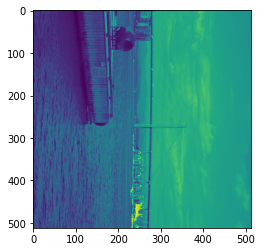

In [175]:
i = 3

print(y)
plt.imshow(x[i].view(512,512))
plt.show()

In [153]:
def train(epoch):
  model.train()
  running_loss, running_accuracy = 0., 0.
  for batch in range(epoch):
    data = next(iter(train_loader_iter))
    img, lab = data["image"], data["label"]
    inputs , labels = preprocess_data(img, lab, False)
    optimizer.zero_grad()
    output, feat_0, feat_1 = model(*inputs)
    loss = criterion_1(output, labels) + 0.1 * criterion_2(feat_0, feat_1, labels)


  #  the_accuracy = accuracy(output, labels).item()
   # running_accuracy += the_accuracy
   # running_loss += loss.item()

    loss.backward()
    optimizer.step()

    print('EPOCH :',batch,"LOSS:", loss.item(), '\n')

In [170]:
def validate(epoch):
  correct = 0
  total = 0
  with torch.no_grad():
    model.eval()
    for d in range(epoch):
      data = next(iter(train_loader_iter))
      image, lab = data["image"], data["label"]
      i, l = preprocess_data(image, lab,False)
      if epoch == 1:
        print(lab)
      output, feat0, feat1 = model(*i)
      for idx, j in enumerate(output):
        print(torch.argmax(j),"--",lab[idx])
        if torch.argmax(j) == lab[idx]:
          correct += 1
        total +=1
  
  print("ACCURACY :", correct/total,"total :",total, "correct :",correct )

In [157]:
train(4)

EPOCH : 0 LOSS: 0.8251492977142334 

EPOCH : 1 LOSS: 0.7688311338424683 

EPOCH : 2 LOSS: 0.9058972597122192 

EPOCH : 3 LOSS: 0.9043429493904114 



In [171]:
validate(1)

tensor([1, 1, 0, 0, 1, 0, 0, 0, 1, 1])
tensor(0) -- tensor(1)
tensor(0) -- tensor(1)
tensor(0) -- tensor(0)
tensor(0) -- tensor(0)
tensor(0) -- tensor(1)
tensor(0) -- tensor(0)
tensor(0) -- tensor(0)
tensor(0) -- tensor(0)
tensor(0) -- tensor(1)
tensor(0) -- tensor(1)
ACCURACY : 0.5 total : 10 correct : 5
